In [1]:
# If you're in Colab or a fresh env
!pip install transformers accelerate datasets torch torchvision torchaudio
!pip install scikit-learn pandas
! pip install tf-keras
! pip install -U transformers



In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Load and merge ---
peptide_df = pd.read_csv("peptide_features.csv")
protein_df = pd.read_csv("protein_features.csv")

merged_df = pd.merge(peptide_df, protein_df, on="protein_id", suffixes=("_pep", "_prot"))

# --- Binarize labels: 1,2 -> 0 (not observed), 3,4,5,6 -> 1 (observed) ---
def binarize_presence(s):
    return s.replace({1:0, 2:0, 3:1, 4:1, 5:1, 6:1})

merged_df["presence_SILAC_bin"] = binarize_presence(merged_df["presence_SILAC"])
merged_df["presence_Label_free_bin"] = binarize_presence(merged_df["presence_Label_free"])

# For this notebook we focus on presence_SILAC_bin
df = merged_df.dropna(subset=["peptide", "presence_SILAC_bin"]).copy()
df["presence_SILAC_bin"] = df["presence_SILAC_bin"].astype(int)

print(df[["peptide", "presence_SILAC", "presence_SILAC_bin"]].head())

# Train / validation / test split on *sequences + label*
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df["presence_SILAC_bin"]
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["presence_SILAC_bin"]
)

print(len(train_df), len(val_df), len(test_df))


           peptide  presence_SILAC  presence_SILAC_bin
0  AYNPLFIYGGVGLGK               3                   1
1      DHTTVIHAHEK               2                   0
2   DHTTVIHAHEKISK               2                   0
3          DIIQAPK               2                   0
4        DIIQAPKSK               2                   0
33917 7268 7268


In [3]:
import transformers
print("Transformers version:", transformers.__version__)
print("Loaded from:", transformers.__file__)
import sys
print("Python executable:", sys.executable)


/home/mohammad/miniconda3/envs/gwas_py/envs/xaidll/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Transformers version: 4.57.1
Loaded from: /home/mohammad/miniconda3/envs/gwas_py/envs/xaidll/lib/python3.12/site-packages/transformers/__init__.py
Python executable: /home/mohammad/miniconda3/envs/gwas_py/envs/xaidll/bin/python3.12


In [4]:
import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

# Choose a protein transformer model
model_name = "facebook/esm2_t6_8M_UR50D"  # or "facebook/esm2_t12_35M_UR50D"

tokenizer = AutoTokenizer.from_pretrained(model_name)

class PeptideESMDataset(Dataset):
    def __init__(self, df, tokenizer, label_col="presence_SILAC_bin", max_length=256):
        self.seqs = df["peptide"].tolist()
        self.labels = df[label_col].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        label = self.labels[idx]

        # ESM tokenizer treats each character as a token
        enc = self.tokenizer(
            seq,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

train_ds = PeptideESMDataset(train_df, tokenizer)
val_ds   = PeptideESMDataset(val_df,   tokenizer)
test_ds  = PeptideESMDataset(test_df,  tokenizer)

len(train_ds), len(val_ds), len(test_ds)


(33917, 7268, 7268)

In [7]:
from transformers import Trainer, TrainingArguments

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1, zero_division=0
    )
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

batch_size = 64  # adjust to your GPU

# ✅ version-compatible TrainingArguments (no evaluation_strategy, etc.)
training_args = TrainingArguments(
    output_dir="./esm2_silac_classifier",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    learning_rate=2e-5,
    logging_steps=50,
    do_eval=True  # allows eval via trainer.evaluate()
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ---- train ----
train_result = trainer.train()
print(train_result)

# ---- validation metrics (loss, acc, precision, recall, f1) ----
eval_metrics = trainer.evaluate()  # runs on val_ds

print("\nValidation metrics:")
# eval_loss comes from Trainer; others from compute_metrics()
for k, v in eval_metrics.items():
    print(f"{k}: {v:.4f}")


/tmp/ipykernel_26787/665810400.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2}.


Step,Training Loss
50,0.580200
100,0.444800
150,0.353600
200,0.346600
250,0.334100
300,0.316600
350,0.311600
400,0.288100
450,0.306100
500,0.296000


TrainOutput(global_step=5300, training_loss=0.21742366466882093, metrics={'train_runtime': 484.8399, 'train_samples_per_second': 699.551, 'train_steps_per_second': 10.931, 'total_flos': 3908219377320960.0, 'train_loss': 0.21742366466882093, 'epoch': 10.0})



Validation metrics:
eval_loss: 0.2769
eval_accuracy: 0.8923
eval_precision: 0.7836
eval_recall: 0.8009
eval_f1: 0.7921
eval_runtime: 4.0820
eval_samples_per_second: 1780.4820
eval_steps_per_second: 27.9270
epoch: 10.0000


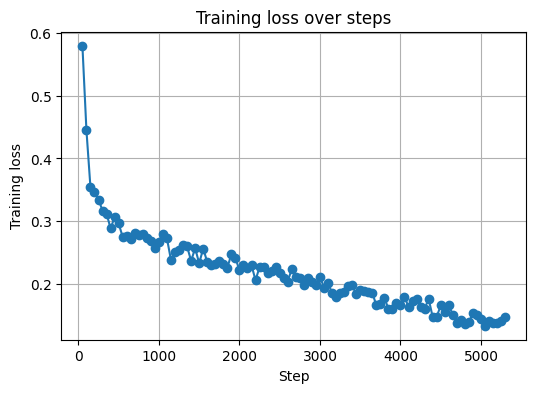

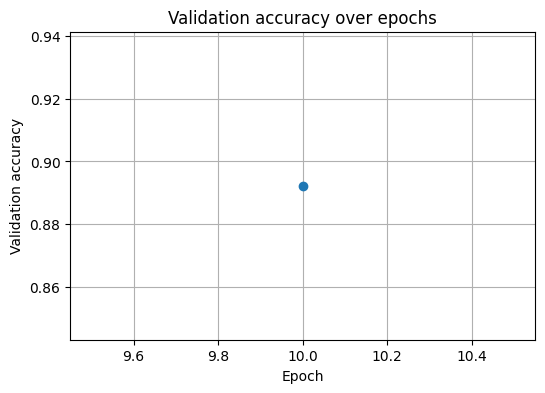

Test metrics: {'accuracy': 0.8874518436984039, 'precision': 0.7753164556962026, 'recall': 0.7894736842105263, 'f1': 0.7823310271420969}

Classification report (test):
              precision    recall  f1-score   support

           0      0.927     0.921     0.924      5406
           1      0.775     0.789     0.782      1862

    accuracy                          0.887      7268
   macro avg      0.851     0.855     0.853      7268
weighted avg      0.888     0.887     0.888      7268



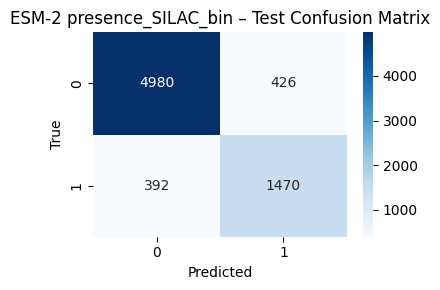


Example predictions on test set:
00 | peptide: EVTFKDEPGVTYVVQPISTNK | true: 1 | pred: 1
01 | peptide: KPGLYK               | true: 0 | pred: 0
02 | peptide: LDPNIR               | true: 0 | pred: 0
03 | peptide: ALMGANMQR            | true: 1 | pred: 1
04 | peptide: GISVTSSVMQFDYDDYK    | true: 1 | pred: 1
05 | peptide: ATNEESYLMQK          | true: 1 | pred: 1
06 | peptide: NKQVDGFTTNPSLMAK     | true: 0 | pred: 0
07 | peptide: DIVAESPDLVIVGGGIANADDPVEAAK | true: 1 | pred: 1
08 | peptide: ETTAIDIPFAAR         | true: 1 | pred: 0
09 | peptide: IRETAR               | true: 0 | pred: 0


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ---------- 1) Training loss & eval accuracy from Trainer logs ----------

log_history = trainer.state.log_history

# Collect training losses
train_steps = []
train_losses = []
for entry in log_history:
    if "loss" in entry and "epoch" in entry:
        train_steps.append(entry.get("step", len(train_steps)))
        train_losses.append(entry["loss"])

# Collect eval accuracy if available
eval_epochs = []
eval_accs = []
for entry in log_history:
    if "eval_accuracy" in entry:
        eval_epochs.append(entry["epoch"])
        eval_accs.append(entry["eval_accuracy"])

# Plot training loss
plt.figure(figsize=(6,4))
plt.plot(train_steps, train_losses, marker="o")
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("Training loss over steps")
plt.grid(True)
plt.show()

# Plot eval accuracy (if present)
if eval_accs:
    plt.figure(figsize=(6,4))
    plt.plot(eval_epochs, eval_accs, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Validation accuracy")
    plt.title("Validation accuracy over epochs")
    plt.grid(True)
    plt.show()
else:
    print("No eval_accuracy logged in trainer.state.log_history (check TrainingArguments / evaluation strategy).")

# ---------- 2) Confusion matrix on test set ----------

test_outputs = trainer.predict(test_ds)
test_logits = test_outputs.predictions
test_labels = test_outputs.label_ids
test_preds = np.argmax(test_logits, axis=-1)

print("Test metrics:", compute_metrics((test_logits, test_labels)))
print("\nClassification report (test):")
print(classification_report(test_labels, test_preds, digits=3, zero_division=0))

cm = confusion_matrix(test_labels, test_preds, labels=[0, 1])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ESM-2 presence_SILAC_bin – Test Confusion Matrix")
plt.tight_layout()
plt.show()

# ---------- 3) Show some example predictions ----------

print("\nExample predictions on test set:")
n_examples = 10
for i in range(min(n_examples, len(test_df))):
    seq = test_df["peptide"].iloc[i]
    true_label = int(test_df["presence_SILAC_bin"].iloc[i])
    pred_label = int(test_preds[i])
    print(f"{i:02d} | peptide: {seq:20s} | true: {true_label} | pred: {pred_label}")
